# Wikipedia App

## "Reduce" with One Mean

__Conclusion__: _It works with RidgeCV, alpha=0.1_

In [1]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import RidgeCV, LinearRegression
from lib import DataFrameBuilder
from lib import Humanizer, Plotter, Model, OneManyModel, TwoMeanModel, Outlier, ExperimentInfo, TaskMeanModel
from mynotebook import *

df_builder = DataFrameBuilder()

## Wikipedia Application

### Target

,input size (GiB),workers,samples,outliers,available
0,45,4,30,3,27
1,45,8,30,1,29
2,45,16,30,1,29
3,45,32,30,2,28
4,45,64,30,3,27


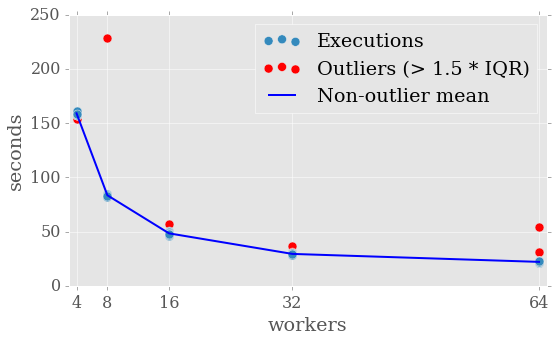

Total target application duration using the complete dataset (45 GB).


In [2]:
target_out = df_builder.get_target_df(stage=0)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((3, 65), (0, 250))
caption = 'Total target application duration using the complete dataset (45 GB).'
target = process_outliers(target_out, humanizer, plotter, caption)

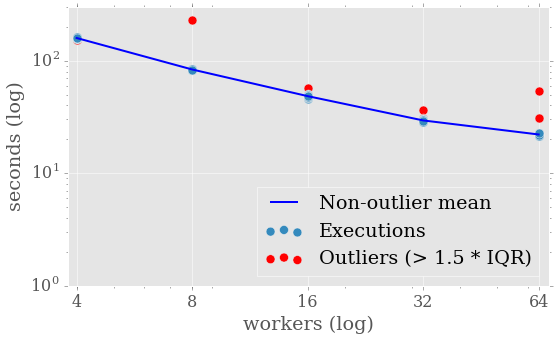

The same as above in log-log scale.


In [3]:
plotter = Plotter((3.8, 68), (1, 300), logx=True, logy=True, loc='lower right')
plotter.plot_outliers(target_out)
print('The same as above in log-log scale.')

### "Reduce" stage

In [4]:
caption = 'Durations of the first tasks using 1-GB input data.'
prof_many_first_out, prof_many_nonfirst_out = df_builder.get_strong_scaling_tasks_df(2, stage=0, threads=2)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])

,workers,input,ms,outlier
89,3,1073741798,9383,False
85,3,1073741798,8917,False
4,1,1073741798,2614,False


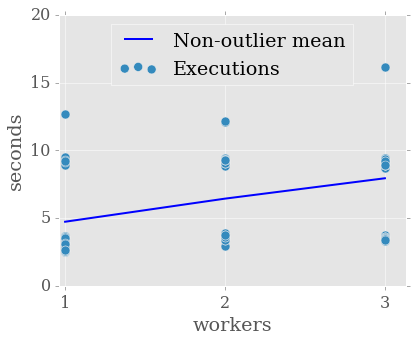

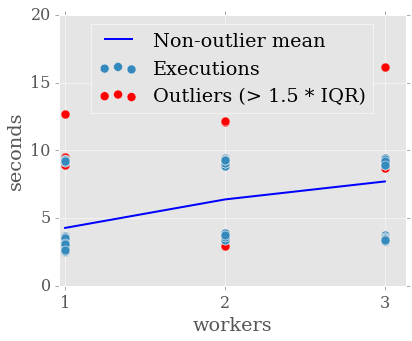

In [18]:
humanizer = Humanizer(size=Humanizer.SIZE_MIB)
plotter = Plotter((0.96, 3.13), (0, 20), logx=False, logy=False, loc='upper center', figsize=(6, 5))

prof_many_out['outlier'] = [False] * len(prof_many_out)
display(prof_many_out.sample(3))
plotter.plot_outliers(prof_many_out)

# Process outliers separately for first and nonfirst tasks
prof_many_first_out['outlier'] = Outlier.is_outlier(prof_many_first_out)
prof_many_nonfirst_out['outlier'] = Outlier.is_outlier(prof_many_nonfirst_out)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])
plotter.plot_outliers(prof_many_out)

prof_many = prof_many_out[~prof_many_out.outlier].drop('outlier', axis=1)

In [19]:
prof = prof_many

display(prof.sample(3))
model = Model(RidgeCV(normalize=True), features=['workers'], ycol='ms', degree=2, use_log=False)
display(model.fit_score(prof))
linreg = model.get_linreg()
display(linreg.intercept_, linreg.coef_)

model_many = model

,workers,input,ms
71,2,1073741798,3667
83,2,1073741798,3545
32,1,1073741798,3261


[0.47635930692090284,
 ((1, 1073741798), 0.49199493022220103),
 ((2, 1073741798), 0.5094377996938247),
 ((3, 1073741798), 0.42805665461776926)]

3378.7121301238503

array([    0.        ,  1033.97489071,   143.7141791 ])

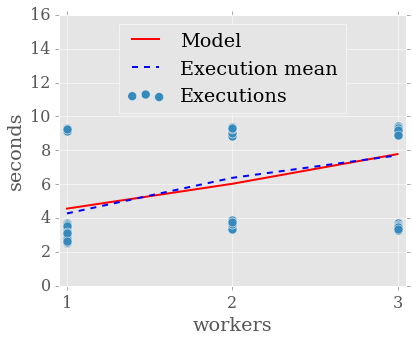

In [20]:
model = model_many
prof = prof_many

plotter = Plotter((0.95, 3.05), (0, 16), loc='upper center', figsize=(6, 5))
plotter.plot_model(model, prof)

In [25]:
prof_one_out = df_builder.get_1VM_df(stage=0)
prof_one = remove_outliers(prof_one_out[prof_one_out.input > 200 * 1024**2])

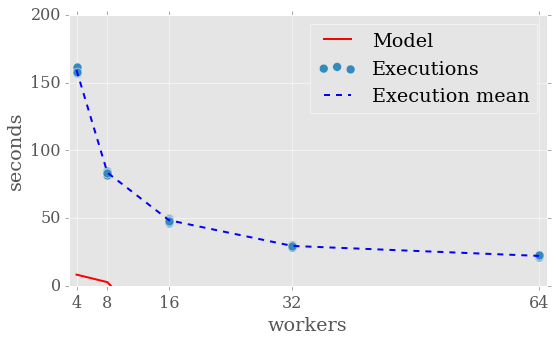

In [32]:
prof = pd.concat([prof_many, prof_one])
prof = prof_many

task_model = Model(LinearRegression(), features=['workers'], ycol='ms', degree=2, use_log=False)
exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024**2)
prof_tasks = exp_info.get_n_tasks(stage=0)
target_tasks = prof_tasks
threads = exp_info.threads
stage_model = TaskMeanModel(task_model, prof_tasks, target_tasks, threads)

stage_model.fit(prof)
plotter = Plotter((3, 65), (0, 200))
plotter.plot_model(stage_model, target)